# SC3000 Lab 1: Balancing a Pole on a Cart

## Installing dependencies:
Run `pip install -r requirements.txt`. <br>
The `requirements.txt` file should be uploaded together with this project.

## Importing dependencies and define helper functions

In [15]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Loading CartPole environment
We will be using the `gym` package for loading the cartpole environment.

In [2]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [3]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [4]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


We call each round of the pole-balancing game an "episode". At the start of each episode, make sure the environment is reset, which chooses a random initial state, e.g., pole slightly tilted to the right. This initialization can be achieved by the code below, which returns the observation of the initial state.

In [5]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.01541311  0.01108449 -0.02908912  0.01506923]


For the CartPole environment, there are two possible actions: 0 for pushing to the left and 1 for pushing to the right. For example, we can push the cart to the left using code below, which returns the new observation, the current reward, an indicator of whether the game ends, and some additional information (not used in this project). For CartPole, the game ends when the pole is significantly tilted or you manage to balance the pole for 500 steps. You get exactly 1 reward for each step before the game ends (i.e., max cumulative reward is 500).

In [6]:
observation, reward, done, info = env.step(0)
print("New observations after choosing action 0:", observation)
print("Reward for this step:", reward)
print("Is this round done?", done)

New observations after choosing action 0: [ 0.0156348  -0.18360847 -0.02878774  0.29843414]
Reward for this step: 1.0
Is this round done? False


/home/yuhaopro/sc3000-project/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# Q-Learning approach
Q-learning is a model-free reinforcement learning algorithm used to learn the value of an action in a particular state without requiring a model of the environment. It works by estimating the values of action-state pairs, represented as 
Q(s,a). The core idea of Q-learning is to iteratively update the 
Q values towards the expected returns, which are estimated based on the rewards observed and the future rewards anticipated, following an optimal policy. The update rule in Q-learning reflects this idea and is designed to minimize the difference between the current Q value estimate and the "target" value that the 
Q value is expected to converge to in the long run.
## Methodology
- Discretize initial state space
- Model Training
- Model Evaluation

## - Discretize initial state space


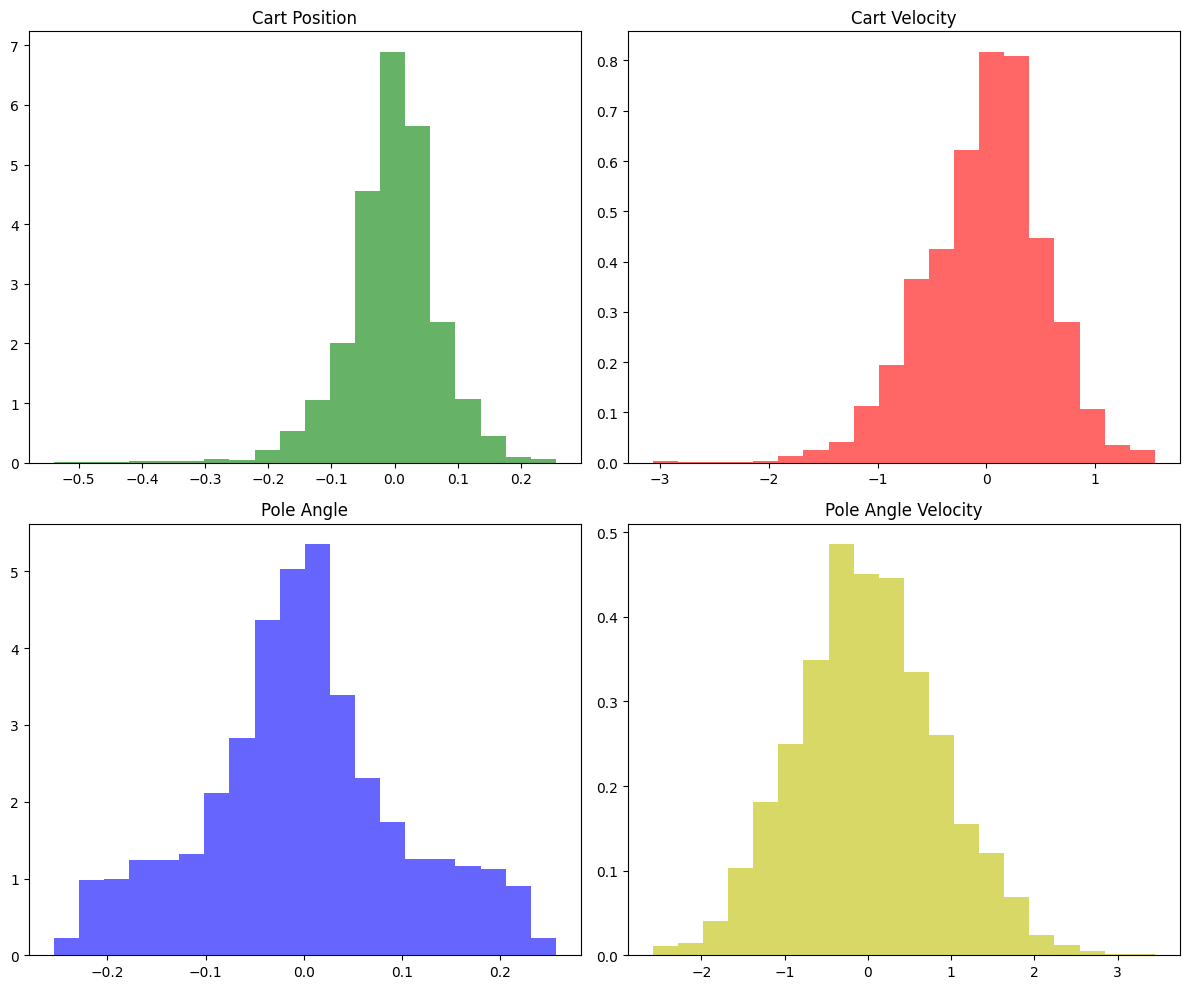

In [24]:
# To find out how we should split the observation space
# run 100 episodes and plot the cart positions on a graph.

def plot_sample_data():
    pos = []
    pos_vel = []
    rad = []
    rad_vel = []

    for _ in range(100):
        observation = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            
            pos.append(observation[0])
            pos_vel.append(observation[1])
            rad.append(observation[2])
            rad_vel.append(observation[3])
            
    # Convert lists to numpy arrays
    pos = np.array(pos)
    pos_vel = np.array(pos_vel)
    rad = np.array(rad)
    rad_vel = np.array(rad_vel)

    # Directly using matplotlib for plotting
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    axs[0, 0].hist(pos, bins=20, density=True, alpha=0.6, color='g')
    axs[0, 0].set_title('Cart Position')

    axs[0, 1].hist(pos_vel, bins=20, density=True, alpha=0.6, color='r')
    axs[0, 1].set_title('Cart Velocity')

    axs[1, 0].hist(rad, bins=20, density=True, alpha=0.6, color='b')
    axs[1, 0].set_title('Pole Angle')

    axs[1, 1].hist(rad_vel, bins=20, density=True, alpha=0.6, color='y')
    axs[1, 1].set_title('Pole Angle Velocity')

    plt.tight_layout()
    plt.show()

plot_sample_data()


In [29]:
# Create the discretized state space
# Initial hypothesis to split the state space into 20 discrete bins.
bins = 20
pos_bins = np.linspace(env.observation_space.low[0], env.observation_space.high[0], bins, endpoint=False)
pos_vel_bins = np.linspace(env.observation_space.low[1], env.observation_space.high[1], bins, endpoint=False)
rad_bins = np.linspace(env.observation_space.low[2], env.observation_space.high[2], bins, endpoint=False)
rad_vel_bins = np.linspace(env.observation_space.low[3], env.observation_space.high[3], bins, endpoint=False)
print(pos_bins, pos_vel_bins, rad_bins, rad_vel_bins)


[-4.80000019 -4.32000017 -3.84000015 -3.36000013 -2.88000011 -2.4000001
 -1.92000008 -1.44000006 -0.96000004 -0.48000002  0.          0.48000002
  0.96000004  1.44000006  1.92000008  2.4000001   2.88000011  3.36000013
  3.84000015  4.32000017] [-3.40282347e+38 -3.06254112e+38 -2.72225877e+38 -2.38197643e+38
 -2.04169408e+38 -1.70141173e+38 -1.36112939e+38 -1.02084704e+38
 -6.80564693e+37 -3.40282347e+37  0.00000000e+00  3.40282347e+37
  6.80564693e+37  1.02084704e+38  1.36112939e+38  1.70141173e+38
  2.04169408e+38  2.38197643e+38  2.72225877e+38  3.06254112e+38] [-0.41887903 -0.37699113 -0.33510323 -0.29321532 -0.25132742 -0.20943952
 -0.16755161 -0.12566371 -0.08377581 -0.0418879   0.          0.0418879
  0.08377581  0.12566371  0.16755161  0.20943952  0.25132742  0.29321532
  0.33510323  0.37699113] [-3.40282347e+38 -3.06254112e+38 -2.72225877e+38 -2.38197643e+38
 -2.04169408e+38 -1.70141173e+38 -1.36112939e+38 -1.02084704e+38
 -6.80564693e+37 -3.40282347e+37  0.00000000e+00  3.4028

In [ ]:
# Split the state space so that most bins end up in the middle
# Use the quantile approach which splits the state space based on number of data points.


## Model Training
Here we will use the discretized state space to update the Q table. 

2

In [27]:
# Initialize the Q table with zeros
# get the number of actions that can be performed at each state.
num_actions = env.action_space.n
q_table = np.zeros((bins, bins, bins, bins, num_actions))

# Define the Q-learning parameters
learning_rate = 0.1
discount_factor = 0.99
epsilon = 0.1
num_episodes = 1000


In [30]:
# Run the Q-learning algorithm
for episode in range(num_episodes):
    # Reset the environment and get the initial observation
    observation = env.reset()
    
    # Discretize the initial observation
    # digitize function here maps the observation data into one of the bins 
    pos_idx = np.digitize(observation[0], pos_bins)
    pos_vel_idx = np.digitize(observation[1], pos_vel_bins)
    rad_idx = np.digitize(observation[2], rad_bins)
    rad_vel_idx = np.digitize(observation[3], rad_vel_bins)
    
    done = False
    cumulative_reward = 0
    
    while not done:
        # Choose an action using epsilon-greedy policy
        if np.random.uniform() < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[pos_idx, pos_vel_idx, rad_idx, rad_vel_idx])  # Exploit
        
        # Take the chosen action and observe the next state and reward
        next_observation, reward, done, info = env.step(action)
        
        # Discretize the next state
        next_pos_idx = np.digitize(next_observation[0], pos_bins)
        next_pos_vel_idx = np.digitize(next_observation[1], pos_vel_bins)
        next_rad_idx = np.digitize(next_observation[2], rad_bins)
        next_rad_vel_idx = np.digitize(next_observation[3], rad_vel_bins)
        
        # Update the Q table using the Q-learning update rule
        q_table[pos_idx, pos_vel_idx, rad_idx, rad_vel_idx, action] += learning_rate * (
            reward + discount_factor * np.max(q_table[next_pos_idx, next_pos_vel_idx, next_rad_idx, next_rad_vel_idx]) -
            q_table[pos_idx, pos_vel_idx, rad_idx, rad_vel_idx, action]
        )
        
        # Update the current state and cumulative reward
        observation = next_observation
        pos_idx = next_pos_idx
        pos_vel_idx = next_pos_vel_idx
        rad_idx = next_rad_idx
        rad_vel_idx = next_rad_vel_idx
        cumulative_reward += reward
    
    # Check if the episode reward is over 500
    if cumulative_reward > 500:
        break

# Print the learned Q table
print(q_table)


[[[[[0. 0.]
    [0. 0.]
    [0. 0.]
    ...
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    ...
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    ...
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   ...

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    ...
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    ...
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    ...
    [0. 0.]
    [0. 0.]
    [0. 0.]]]


  [[[0. 0.]
    [0. 0.]
    [0. 0.]
    ...
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    ...
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    ...
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   ...

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    ...
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    ...
    [0. 0.]
    [0. 0.]
    [0. 0.]]

   [[0. 0.]
    [0. 0.]
    [0. 0.]
    ...
    [0. 0.]
    [0. 0.]
    [0. 0.]]

Now we can play a full round of the game using a naive strategy (always choosing action 0), and show the cumulative reward in the round. Note that reward returned by env.step(*) corresponds to the reward for current step. So we have to accumulate the reward for each step. Clearly, the naive strategy performs poorly by surviving only a dozen of steps.

In [9]:
observation = env.reset()
cumulative_reward = 0
done = False
while not done:
    observation, reward, done, info = env.step(0)
    cumulative_reward += reward
print("Cumulative reward for this round:", cumulative_reward)

Cumulative reward for this round: 10.0


## Task 1: Development of an RL agent

An example of a naive agent is given below, which randomly chooses an action regardless of the observation:

In [10]:
def rand_policy_agent(observation):
    return random.randint(0, 1)

For Task 1, we can show the observation and chosen action below:

In [11]:
observation = env.reset()
action = rand_policy_agent(observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [-0.03716708  0.01291504 -0.0418279   0.00824058]
Chosen action: 0


## Task 2: Demonstrate the effectiveness of the RL agent

For this task, use the agent developed in Task 1 to play the game for 100 episodes (refer to tutorial for how to play a round), record the cumulative reward for each round, and plot the reward for each round. A sample plotting code is given below. Note that you must include code to play for 100 episodes and use the code to obtain round_results for plotting. DO NOT record the round results in advance and paste the results to the notebook.

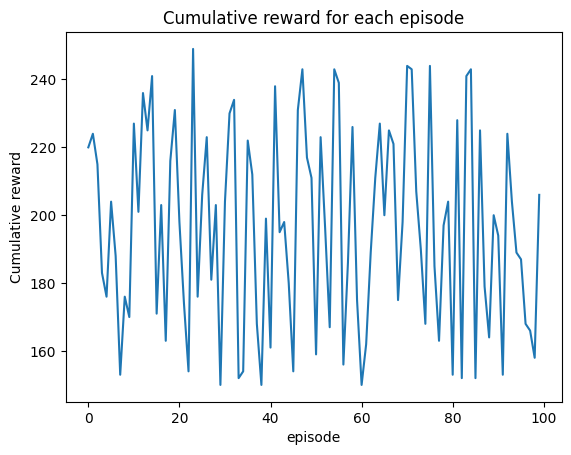

In [12]:
episode_results = np.random.randint(150, 250, size=100)
plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [13]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

Average cumulative reward: 196.49
Is my agent good enough? True


## Task 3: Render one episode played by the agent

Plug your agent to the code below to obtain rendered result.

In [14]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action = rand_policy_agent(observation)
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

/home/yuhaopro/sc3000-project/.venv/lib/python3.10/site-packages/imageio_ffmpeg/_utils.py:7: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename
/home/yuhaopro/sc3000-project/.venv/lib/python3.10/site-packages/pkg_resources/__init__.py:2846: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('mpl_toolkits')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/home/yuhaopro/sc3000-project/.venv/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
